In [ ]:
# import pandas as pd
# import numpy as np
# import sqlite3
# import os

# def generate_bank_dataset(db_path="data/bank.db"):
#     np.random.seed(42)
#     n_samples = 1000

#     df = pd.DataFrame({
#         "age": np.random.randint(18, 70, size=n_samples),
#         "income": np.random.normal(50000, 15000, size=n_samples).astype(int),
#         "education": np.random.choice(["high_school", "bachelor", "master", "phd"], size=n_samples),
#         "branch_visits": np.random.poisson(2, size=n_samples),
#         "channel_preference": np.random.choice(["online", "phone", "in-branch"], size=n_samples),
#         "customer_engagement": np.random.uniform(0, 1, size=n_samples),
#         "region_code": np.random.choice(["north", "south", "east", "west"], size=n_samples),
#         "promotion_offer": np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
#         "activated_ib": 0  # placeholder
#     })

#     # Simulate treatment effect
#     df["activated_ib"] = (
#         0.1 * df["promotion_offer"] +
#         0.02 * df["branch_visits"] +
#         0.3 * df["customer_engagement"] +
#         np.random.normal(0, 0.1, size=n_samples)
#     ) > 0.4

#     df["activated_ib"] = df["activated_ib"].astype(int)

#     os.makedirs(os.path.dirname(db_path), exist_ok=True)
#     with sqlite3.connect(db_path) as conn:
#         df.to_sql("customer_data", conn, if_exists="replace", index=False)

#     print(f"✅ Sample dataset saved to {db_path}")

# if __name__ == "__main__":
#     generate_bank_dataset()

✅ Sample dataset saved to data/bank.db


c:\Users\hangh\miniconda3\envs\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


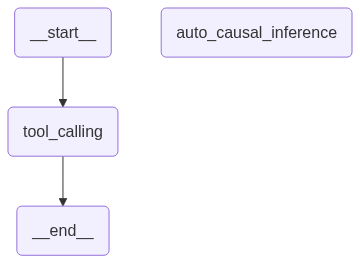

In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from tools import auto_causal_inference, custom_tools_condition, VARIABLE_INFO_DICT

# Create LLM instance
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Bind tool to LLM
llm_with_tools = llm.bind_tools([auto_causal_inference])

# Node for calling LLM
def tool_calling(state: MessagesState):
    VARIABLE_DESC = "The available variables are:\n" + "\n".join(
        [f"- {var}: {desc}" for var, desc in VARIABLE_INFO_DICT.items()]
    )
    
    # Extract original user question
    user_msg = next((m for m in state["messages"] if isinstance(m, HumanMessage)), None)
    if not user_msg:
        raise ValueError("Missing user question.")

    full_prompt = f"""
                    You are a causal inference assistant.
                    {VARIABLE_DESC}

                    User question:
                    "{user_msg.content.strip()}"

                    Please identify the treatment and outcome variables from the question, 
                    and use the `auto_causal_inference` tool to perform causal inference.
                  """
    
    return {"messages": [llm_with_tools.invoke([HumanMessage(content=full_prompt)])]}

# Define graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling", tool_calling)
builder.add_node("auto_causal_inference", ToolNode([auto_causal_inference]))

builder.add_edge(START, "tool_calling")
builder.add_conditional_edges("tool_calling", custom_tools_condition)
builder.add_edge("auto_causal_inference", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import ToolMessage
import json

human_prompt = "Does offering a promotion increase digital product activation ?"
# human_prompt = "Do branch visits increase engagement?"

messages = [HumanMessage(content=human_prompt)]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

#
print("\n\n===========================================================================")
print("Detailed result of Causal Inference:")
tool_msg = next((m for m in messages["messages"] if isinstance(m, ToolMessage)), None)

if tool_msg:
    try:
        result = json.loads(tool_msg.content)
        for key, value in result.items():
            print(f"\n🔑 {key}:\n")
            if isinstance(value, list):
                for item in value:
                    print(f"  - {item}")
            else:
                if key == "causal_graph":
                    # Extract edges from DOT string
                    lines = value.strip().replace("digraph {", "").replace("}", "").strip().split(";")
                    for line in lines:
                        if "->" in line:
                            src, dst = map(str.strip, line.strip().split("->"))
                            print(f"  {src} → {dst}")
                else:
                    print(value)
    except json.JSONDecodeError as e:
        print("❌ Failed to parse tool content as JSON.")
        print("Raw content:", tool_msg.content)
else:
    print("❌ No ToolMessage found in output.")

c:\Users\hangh\miniconda3\envs\python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


================================ Human Message =================================

Does offering a promotion increase digital product activation ?
================================== Ai Message ==================================
Tool Calls:
  auto_causal_inference (call_pxJLcWgsosfGnWAy1TIELCec)
 Call ID: call_pxJLcWgsosfGnWAy1TIELCec
  Args:
    treatment: promotion_offer
    outcome: activated_ib
================================= Tool Message =================================
Name: auto_causal_inference

{"treatment": ["promotion_offer"], "outcome": ["activated_ib"], "confounders": ["age", "income", "education", "branch_visits", "channel_preference", "region_code"], "mediators": ["customer_engagement"], "effect_modifiers": [], "colliders": [], "instruments": [], "causal_graph": "digraph {promotion_offer -> activated_ib; age -> promotion_offer; income -> promotion_offer; education -> promotion_offer; branch_visits -> promotion_offer; channel_preference -> promotion_offer; region_code ->